# Modeling the first wave of COVID-19 in Massachusetts

In this tutorial we will develop an epidemic models for COVID-19 and we will calibrate it to real data on weekly deaths during the first wave in Massachusetts, US. 

Let's import needed packages:

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from epydemix.model import EpiModel, simulate
from epydemix.population import load_epydemix_population
from epydemix.visualization import plot_quantiles, plot_posterior_distribution, plot_posterior_distribution_2d
from epydemix.calibration import ABCSampler
from epydemix.utils import compute_simulation_dates, convert_to_2Darray
from epydemix.calibration.metrics import wmape
import numpy as np 
from datetime import datetime
from scipy import stats 

Second, we import and plot the epidemic data on weekly COVID-19 deaths that we want to model ([source](https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/state/new-york/)):

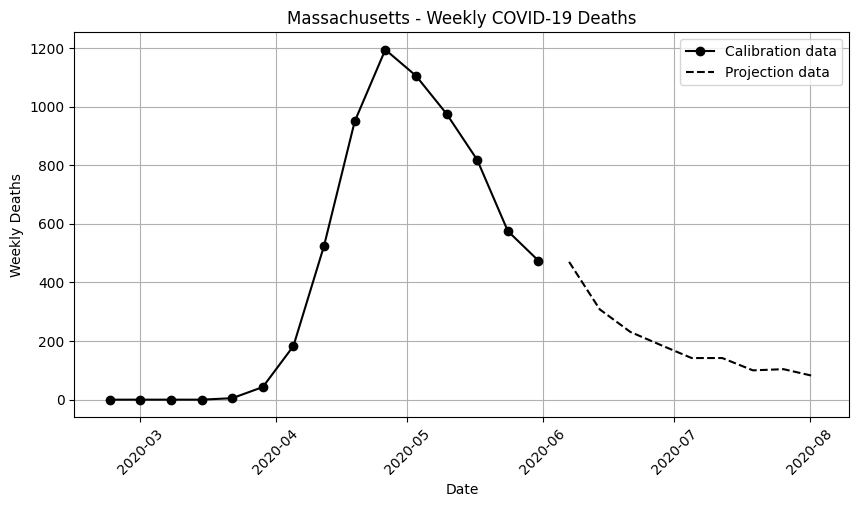

In [2]:
# Load epidemiological data
epi_data = pd.read_csv("./data/massachusetts_data/MA_deaths.csv", parse_dates=["date"])

# Split data into calibration and projection periods
calibration_cutoff = datetime(2020, 6, 1)
epi_data_calibration = epi_data[epi_data.date < calibration_cutoff]
epi_data_projection = epi_data[epi_data.date >= calibration_cutoff]

# Plot calibration and projection data
plt.figure(figsize=(10, 5))
plt.plot(
    epi_data_calibration.date, epi_data_calibration.data, 
    marker="o", color="k", label="Calibration data"
)
plt.plot(
    epi_data_projection.date, epi_data_projection.data, 
    linestyle="--", color="k", label="Projection data"
)

# Formatting the plot
plt.legend()
plt.title("Massachusetts - Weekly COVID-19 Deaths")
plt.xlabel("Date")
plt.ylabel("Weekly Deaths")
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()


Then, we import mobility data from the COVID-19 Community Mobility Report published by Google. Since the first wave of COVID-19 was controlled via the implementation of non-pharmaceutical interventions, we need to account for this into our model. We will use mobility data to compute a contact reduction parameter $r(t)$ that will modulate the transmission rate of our epidemic model. For more detail on similar approaches see [here](https://www.medrxiv.org/content/10.1101/2024.11.08.24316998v1).

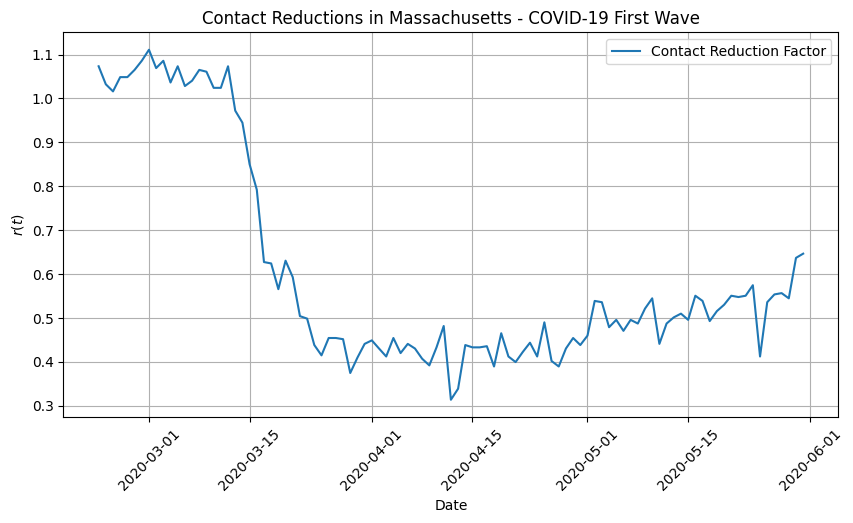

In [3]:
def compute_contact_reductions(mob_data, columns=None):
    """Compute contact reduction factor from mobility data."""
    if columns is None:
        columns = [
            "retail_and_recreation_percent_change_from_baseline",
            "grocery_and_pharmacy_percent_change_from_baseline",
            "transit_stations_percent_change_from_baseline",
            "workplaces_percent_change_from_baseline",
            "residential_percent_change_from_baseline",
        ]

    return pd.DataFrame(
        {
            "date": mob_data.date,
            "r": (1 + mob_data[columns].mean(axis=1) / 100) ** 2,
        }
    )

# Load mobility data
mob_data = pd.read_csv("./data/massachusetts_data/MA_google.csv", parse_dates=["date"])

# Filter mobility data to match the calibration period
mob_data = mob_data.loc[
    (mob_data.date >= epi_data_calibration.date.min()) &
    (mob_data.date <= epi_data_calibration.date.max())
]

# Compute contact reductions
contact_reductions = compute_contact_reductions(mob_data=mob_data)

# Plot contact reductions over time
plt.figure(figsize=(10, 5))
plt.plot(contact_reductions.date, contact_reductions.r, label="Contact Reduction Factor")
plt.title("Contact Reductions in Massachusetts - COVID-19 First Wave")
plt.xticks(rotation=45)
plt.ylabel("$r(t)$")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


We are ready to create the epidemic model. We will implement a SEIR-like model, with the addition of compartments to represent COVID-19 deaths. The model follows this schema:

![Alt text](./img/model_seird.png)


The multiple $D_i$ compartments are introduced to make the transitions from recovery to deaths Erlang distributed. 

In [4]:
# Define Epydemix model with compartments
model = EpiModel(compartments=["S", "E", "I", "R", "D0", "D1", "D2", "D3", "D4"])

# Set Massachusetts population with 10 age groups
population_ma = load_epydemix_population(
    "United_States_Massachusetts",
    age_group_mapping={
        "0-9": np.arange(0, 10).astype(str),
        "10-19": np.arange(10, 20).astype(str),
        "20-29": np.arange(20, 30).astype(str),
        "30-39": np.arange(30, 40).astype(str),
        "40-49": np.arange(40, 50).astype(str),
        "50-59": np.arange(50, 60).astype(str),
        "60-69": np.arange(60, 70).astype(str),
        "70-79": np.arange(70, 80).astype(str),
        "80+": np.concatenate((np.arange(80, 84), ["84+"])).astype(str),
    },
)
model.set_population(population_ma)

# Set model parameters
model.add_parameter(
    parameters_dict={
        "mu": 1.0 / 2.5,  # Recovery rate
        "eps": 1.0 / 4.0,  # Incubation rate
        "r": contact_reductions["r"].values,  # Contact reduction factor
        "IFR": convert_to_2Darray(
            [
                0.00161 / 100,
                0.00695 / 100,
                0.0309 / 100,
                0.0844 / 100,
                0.161 / 100,
                0.595 / 100,
                1.93 / 100,
                4.28 / 100,
                7.80 / 100,
            ]
        ),  # Infection Fatality Rate per age group
    }
)

# Add compartment transitions
model.add_transition(source="S", target="E", params=("beta*r", "I"), kind="mediated")  # Infection
model.add_transition(source="E", target="I", params="eps", kind="spontaneous")  # Incubation to infectious
model.add_transition(source="I", target="R", params="mu*(1-IFR)", kind="spontaneous")  # Recovery
model.add_transition(source="I", target="D0", params="mu*IFR", kind="spontaneous")  # Progression to death

# Sequential progression through death compartments
for d in range(4):
    model.add_transition(source=f"D{d}", target=f"D{d+1}", params="4./Delta", kind="spontaneous")

We define a function to create a seasonal modulation of the transmissibility due to seasonal changes in temperature, humidity, and other factors that may affect transmission:

In [5]:
def apply_seasonality(start_date, end_date, seasonality_min, seasonality_max=1):
    """Compute seasonal modulation factors over a date range."""
    seasonality_factors = []
    start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)

    for day in pd.date_range(start_date, end_date):
        day_max = datetime(day.year, 1, 15)  # Peak seasonality date
        s_r = seasonality_min / seasonality_max
        factor = 0.5 * ((1 - s_r) * np.sin(2 * np.pi / 365 * (day - day_max).days + 0.5 * np.pi) + 1 + s_r)
        seasonality_factors.append(factor)

    return np.array(seasonality_factors)

We are almost ready for the calibration. We write a function to compute initial conditions (total initial infected are split accordingly among age groups), and we define the simulation wrapper:

In [6]:
# Compute the aggregated contact matrix
C = np.sum([c for _, c in model.population.contact_matrices.items()], axis=0)

def compute_beta(C, mu, R0): 
    """Compute the transmission rate beta from R0 and the contact matrix."""
    return R0 * mu / np.linalg.eigvals(C).real.max()

def custom_initial_conditions(epimodel, I0): 
    """Generate initial conditions for the epidemic model."""
    infected_by_age = np.random.multinomial(I0, epimodel.population.Nk / epimodel.population.Nk.sum())
    return {
        "S": epimodel.population.Nk - infected_by_age,
        "E": (infected_by_age / 2).astype(int),
        "I": (infected_by_age / 2).astype(int),
    }

def simulate_wrapper(parameters): 
    """Wrapper function to set up and run the simulation."""
    # Set initial conditions
    initial_conditions = custom_initial_conditions(parameters["epimodel"], parameters["I0"])
    parameters.update({"initial_conditions_dict": initial_conditions})

    # Compute beta from R0
    beta0 = compute_beta(C, parameters["epimodel"].parameters["mu"], parameters["R0"])

    # Compute seasonality factor
    seasonal_factor = apply_seasonality(
        parameters["start_date"], parameters["end_date"], parameters["seasonality_min"]
    )
    
    parameters.update({"beta": beta0 * seasonal_factor})
    results = simulate(**parameters)

    return {"data": results.transitions["D3_to_D4_total"]}

# Define prior distributions for parameters
priors = {
    "R0": stats.uniform(1.5, 6.0 - 1.5),
    "Delta": stats.randint(7, 28),
    "I0": stats.randint(10, 9990),
    "seasonality_min": stats.uniform(0.6, 1.0 - 0.6),
}

# Compute simulation date range
simulation_dates = compute_simulation_dates(
    start_date=epi_data_calibration.date.values[0], 
    end_date=epi_data_calibration.date.values[-1]
)

# Define model parameters
parameters = {
    "epimodel": model,
    "start_date": epi_data_calibration.date.values[0],
    "end_date": epi_data_calibration.date.values[-1],
    "resample_frequency": "W",
}

In [7]:
# Initialize the ABCSampler object
abc_sampler = ABCSampler(
    simulation_function=simulate_wrapper,
    priors=priors,
    parameters=parameters,
    observed_data=epi_data_calibration["data"].values,
    distance_function=wmape,
)

# Run ABC-SMC calibration
results = abc_sampler.calibrate(
    strategy="smc",
    num_particles=1000,
    num_generations=10
)

Starting ABC-SMC with 1000 particles and 10 generations

Generation 1/10 (epsilon: inf)
	Accepted 1000/1000 (acceptance rate: 100.00%)
	Elapsed time: 00:02:05

Generation 2/10 (epsilon: 5.073401)
	Accepted 1000/2029 (acceptance rate: 49.29%)
	Elapsed time: 00:07:49

Generation 3/10 (epsilon: 1.667178)
	Accepted 1000/2177 (acceptance rate: 45.93%)
	Elapsed time: 00:08:07

Generation 4/10 (epsilon: 0.779360)
	Accepted 1000/2482 (acceptance rate: 40.29%)
	Elapsed time: 00:08:52

Generation 5/10 (epsilon: 0.546524)
	Accepted 1000/3519 (acceptance rate: 28.42%)
	Elapsed time: 00:11:49

Generation 6/10 (epsilon: 0.403959)
	Accepted 1000/5201 (acceptance rate: 19.23%)
	Elapsed time: 00:15:53

Generation 7/10 (epsilon: 0.317923)
	Accepted 1000/6576 (acceptance rate: 15.21%)
	Elapsed time: 00:20:23

Generation 8/10 (epsilon: 0.268332)
	Accepted 1000/8434 (acceptance rate: 11.86%)
	Elapsed time: 00:22:22

Generation 9/10 (epsilon: 0.233859)
	Accepted 1000/12228 (acceptance rate: 8.18%)
	Elapsed 

We plot the fitted weekly deaths along with reported ones:

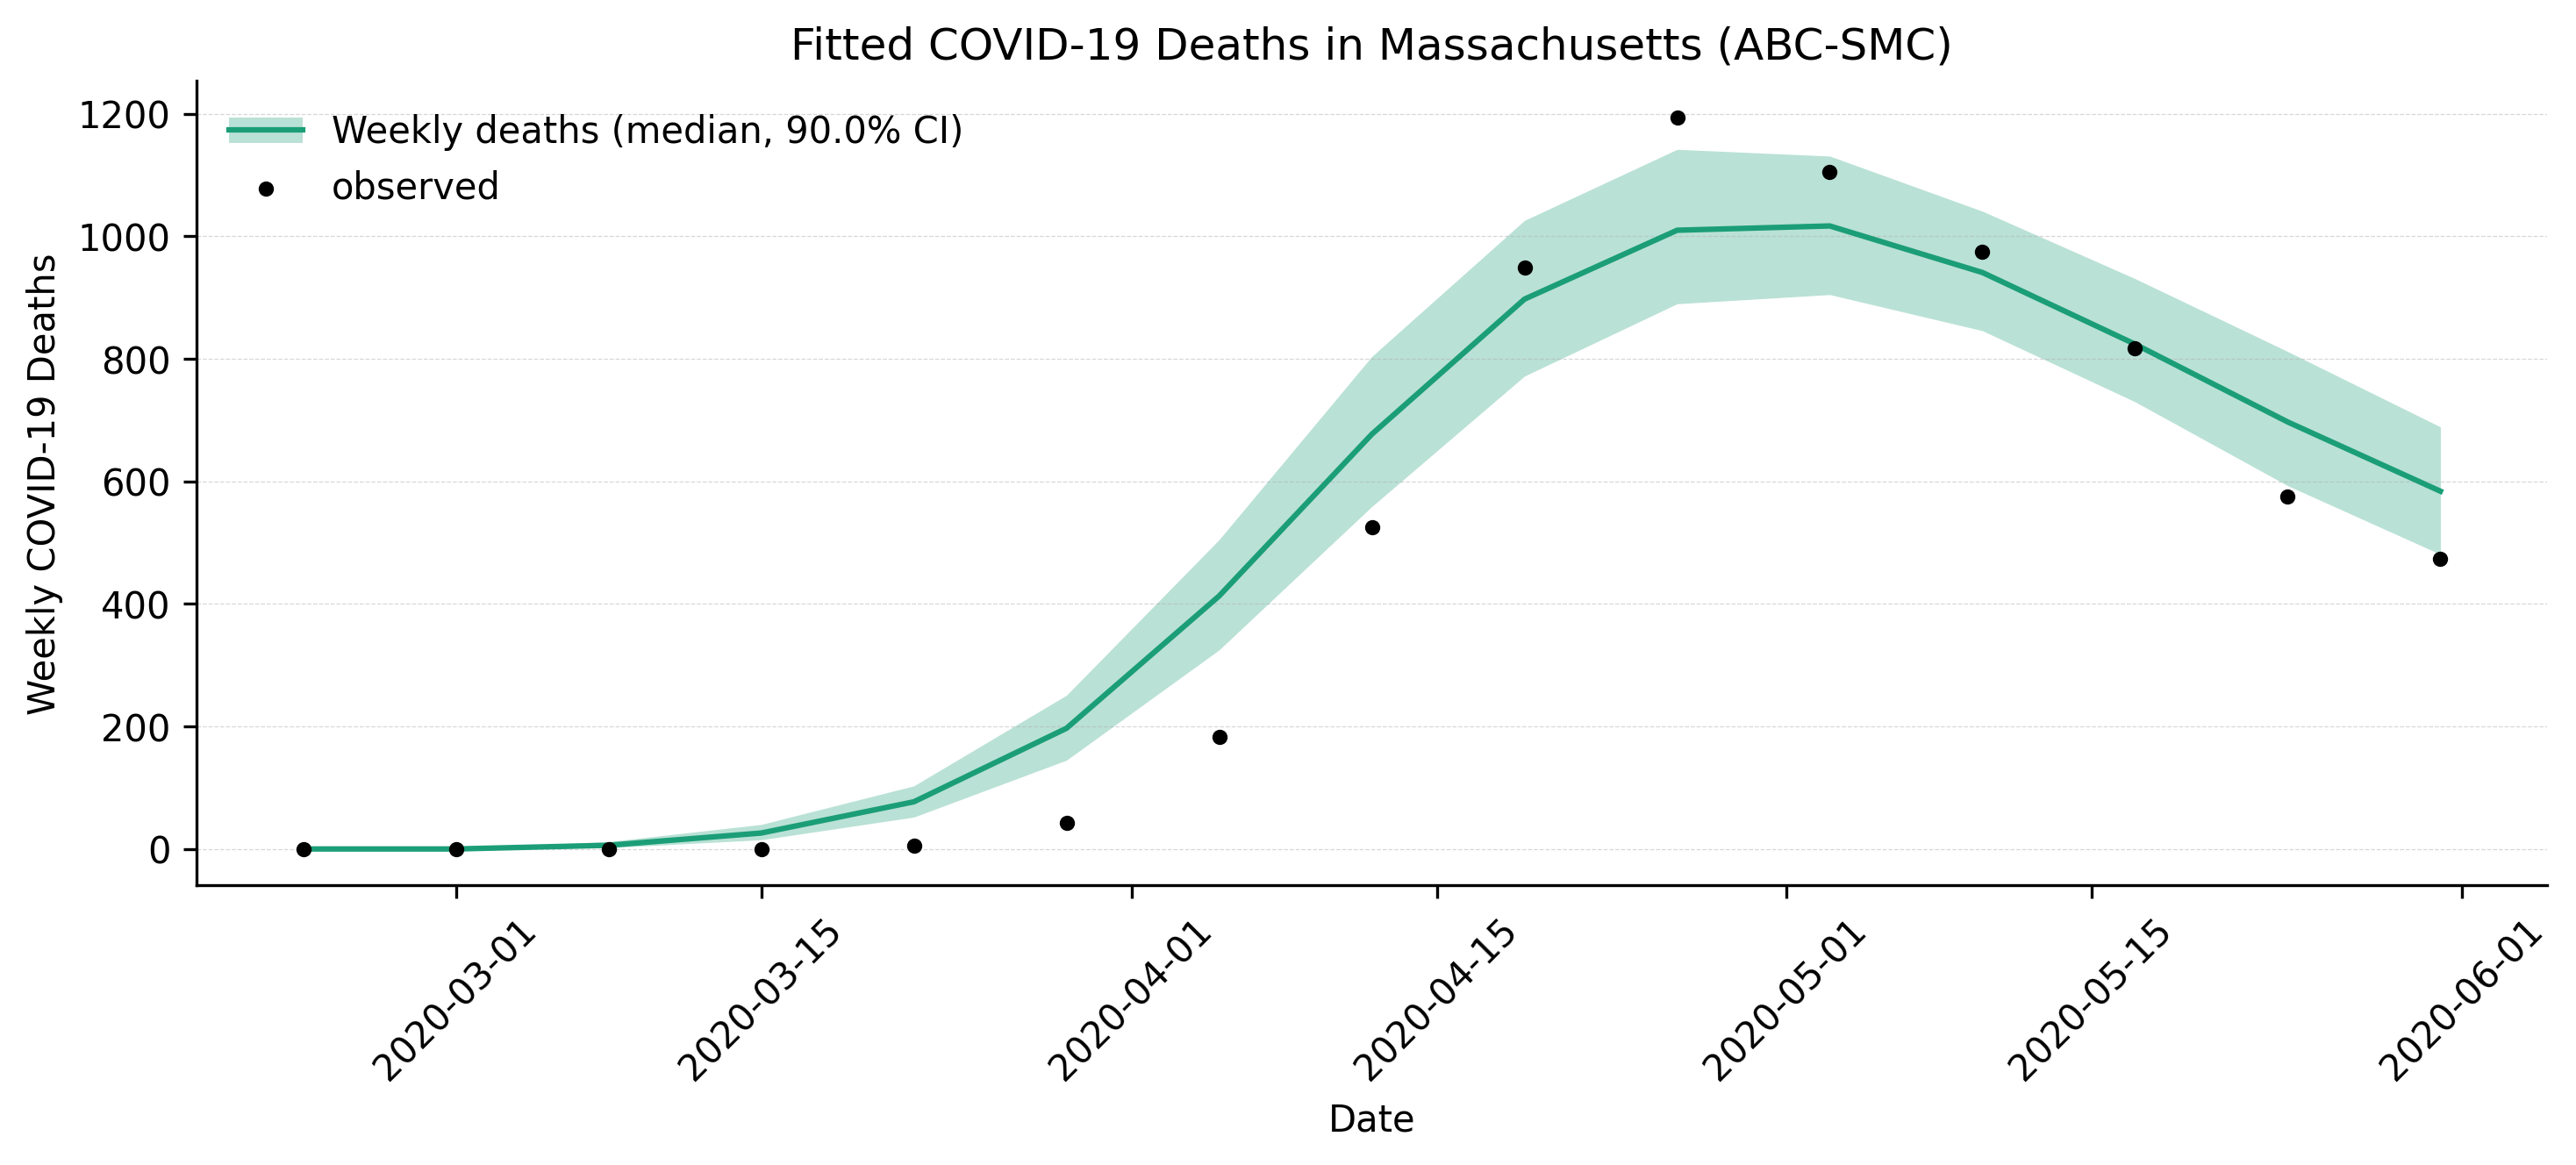

In [8]:
ax = plot_quantiles(
    results.get_calibration_quantiles(dates=epi_data_calibration.date.values),
    data=epi_data_calibration,
    columns="data",
    title="Fitted COVID-19 Deaths in Massachusetts (ABC-SMC)",
    show_data=True,
    xlabel="Date",
    ylabel="Weekly COVID-19 Deaths",
    labels=["Weekly deaths"],
)
ax.tick_params(axis="x", labelrotation=45)


We plot the posterior distributions of free parameters:

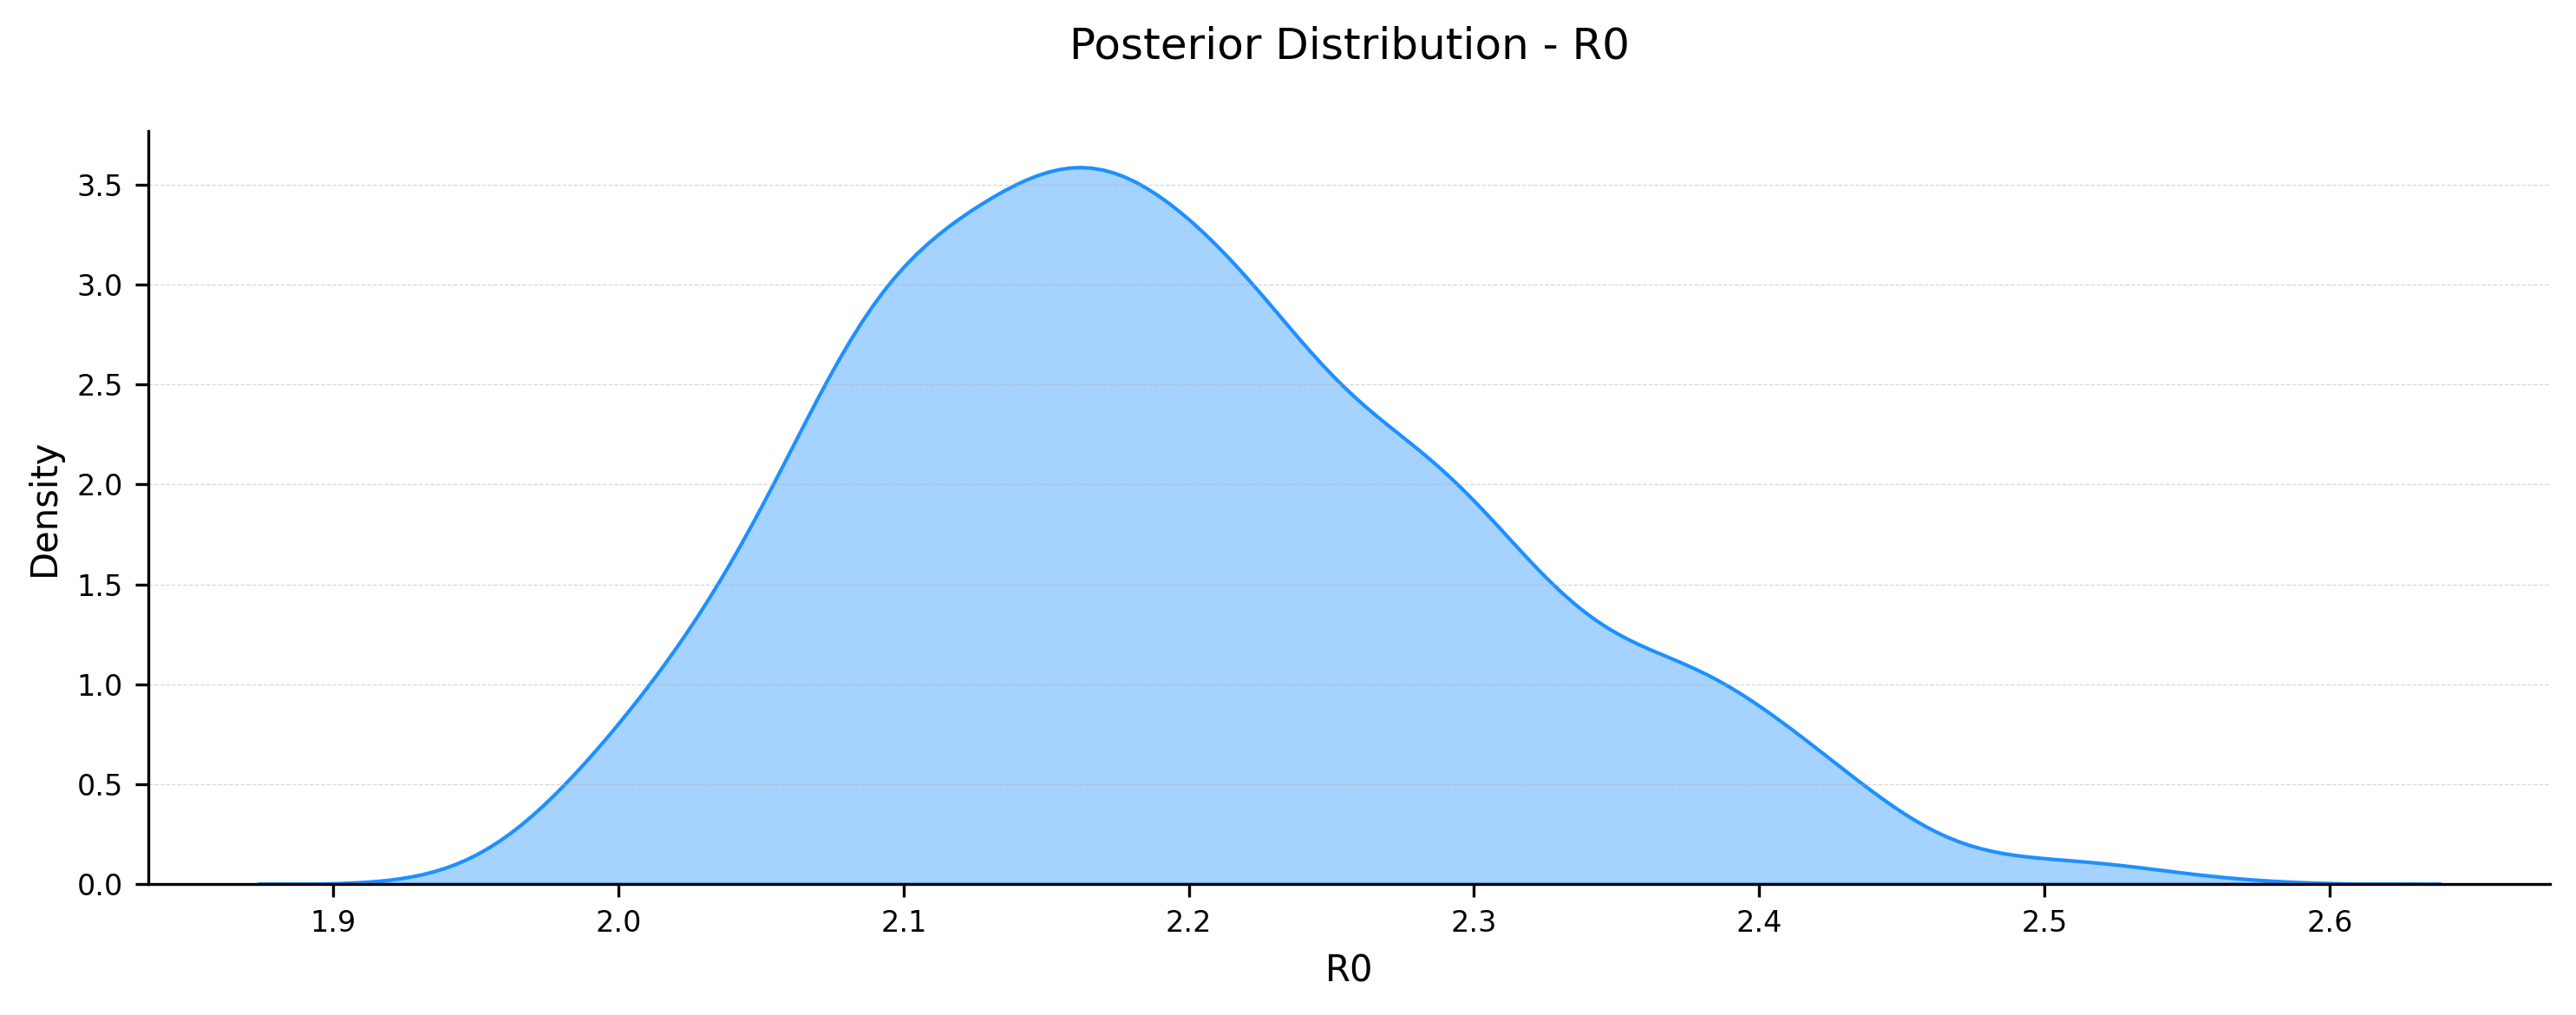

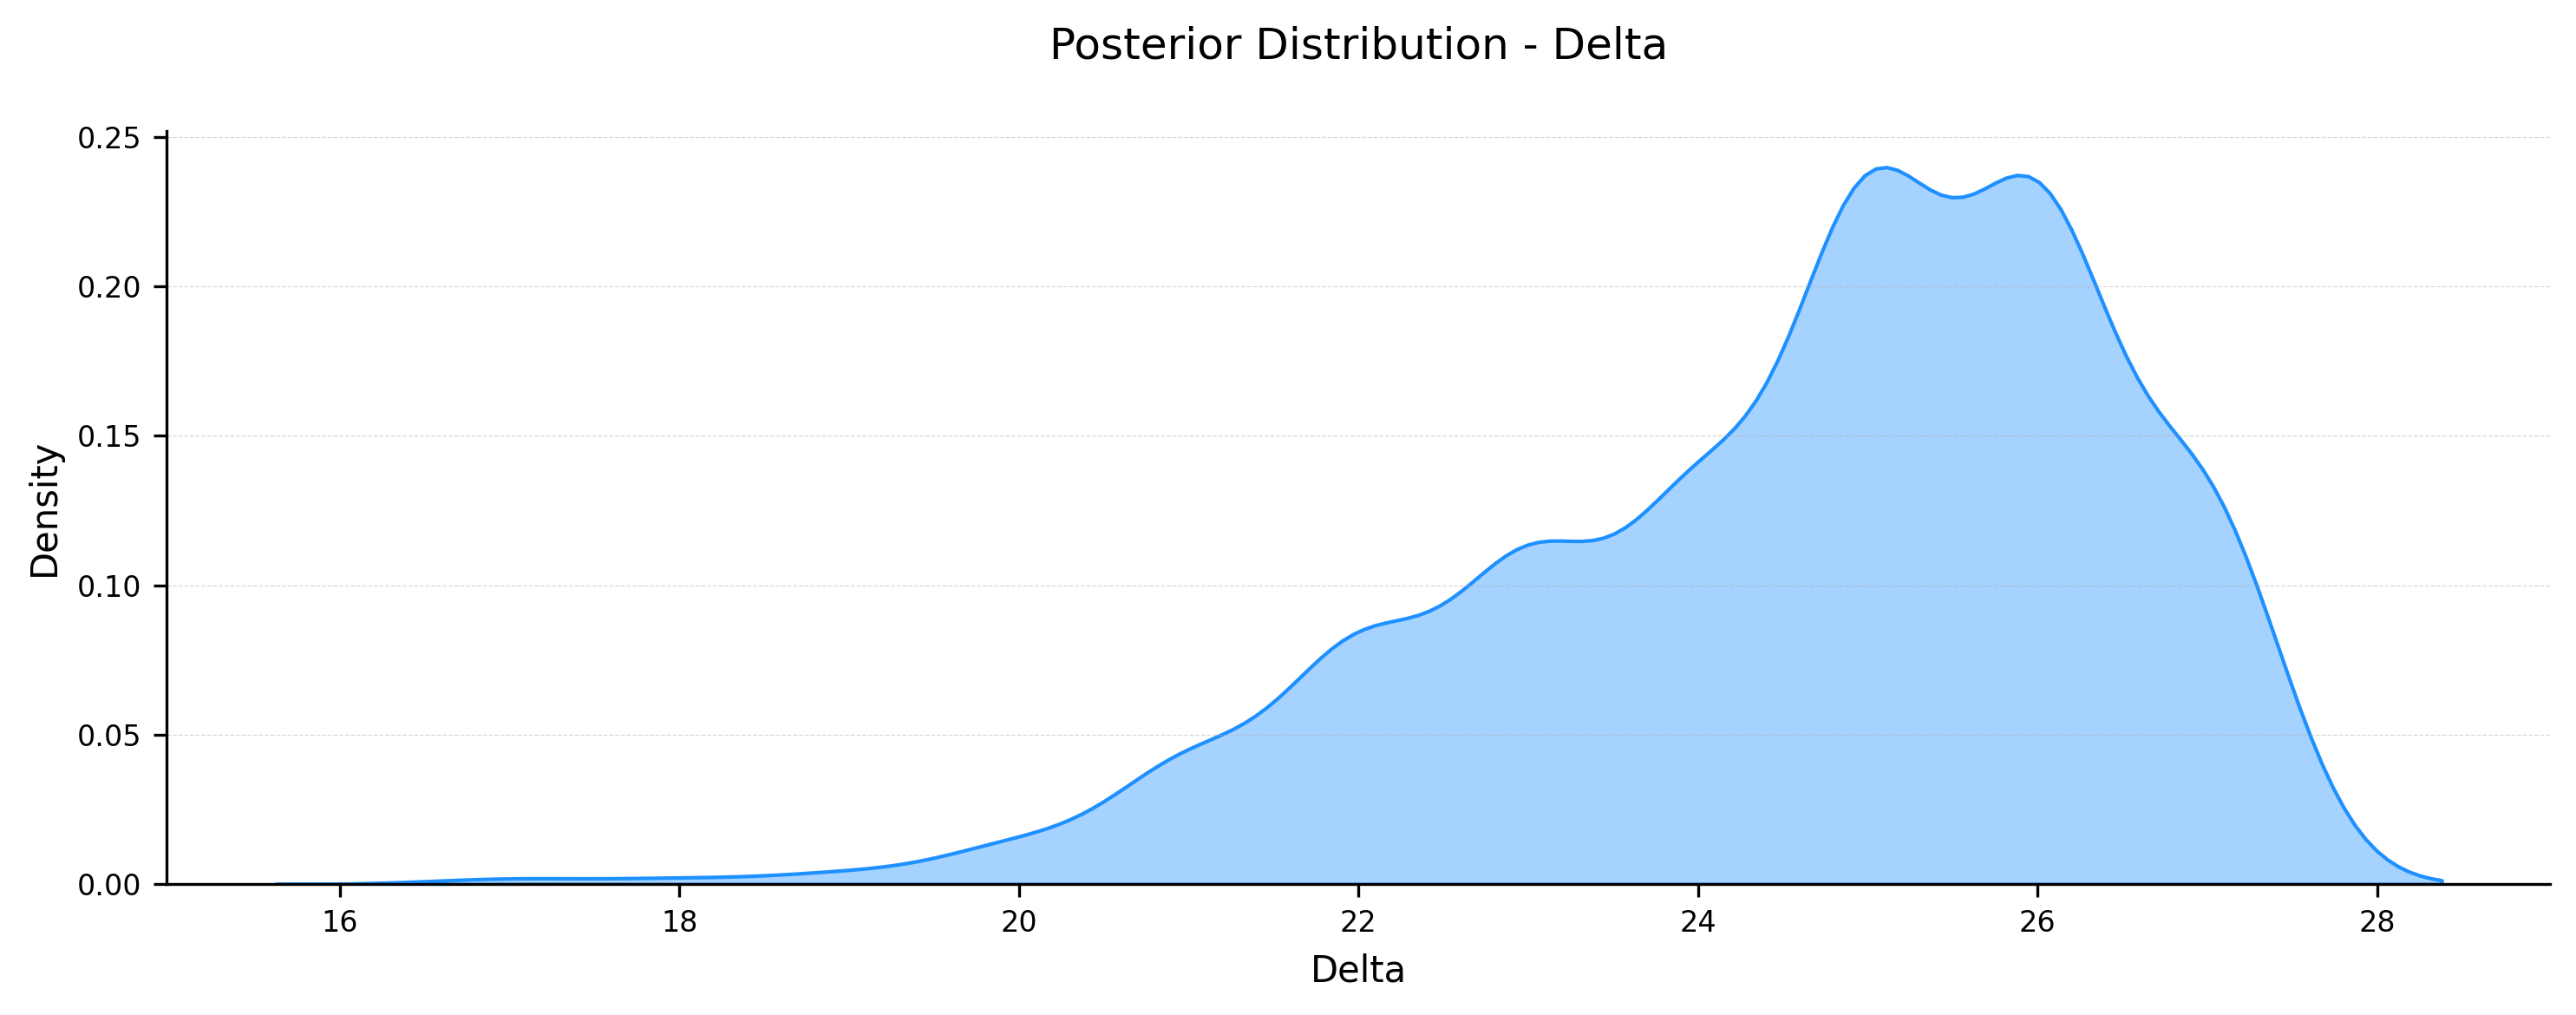

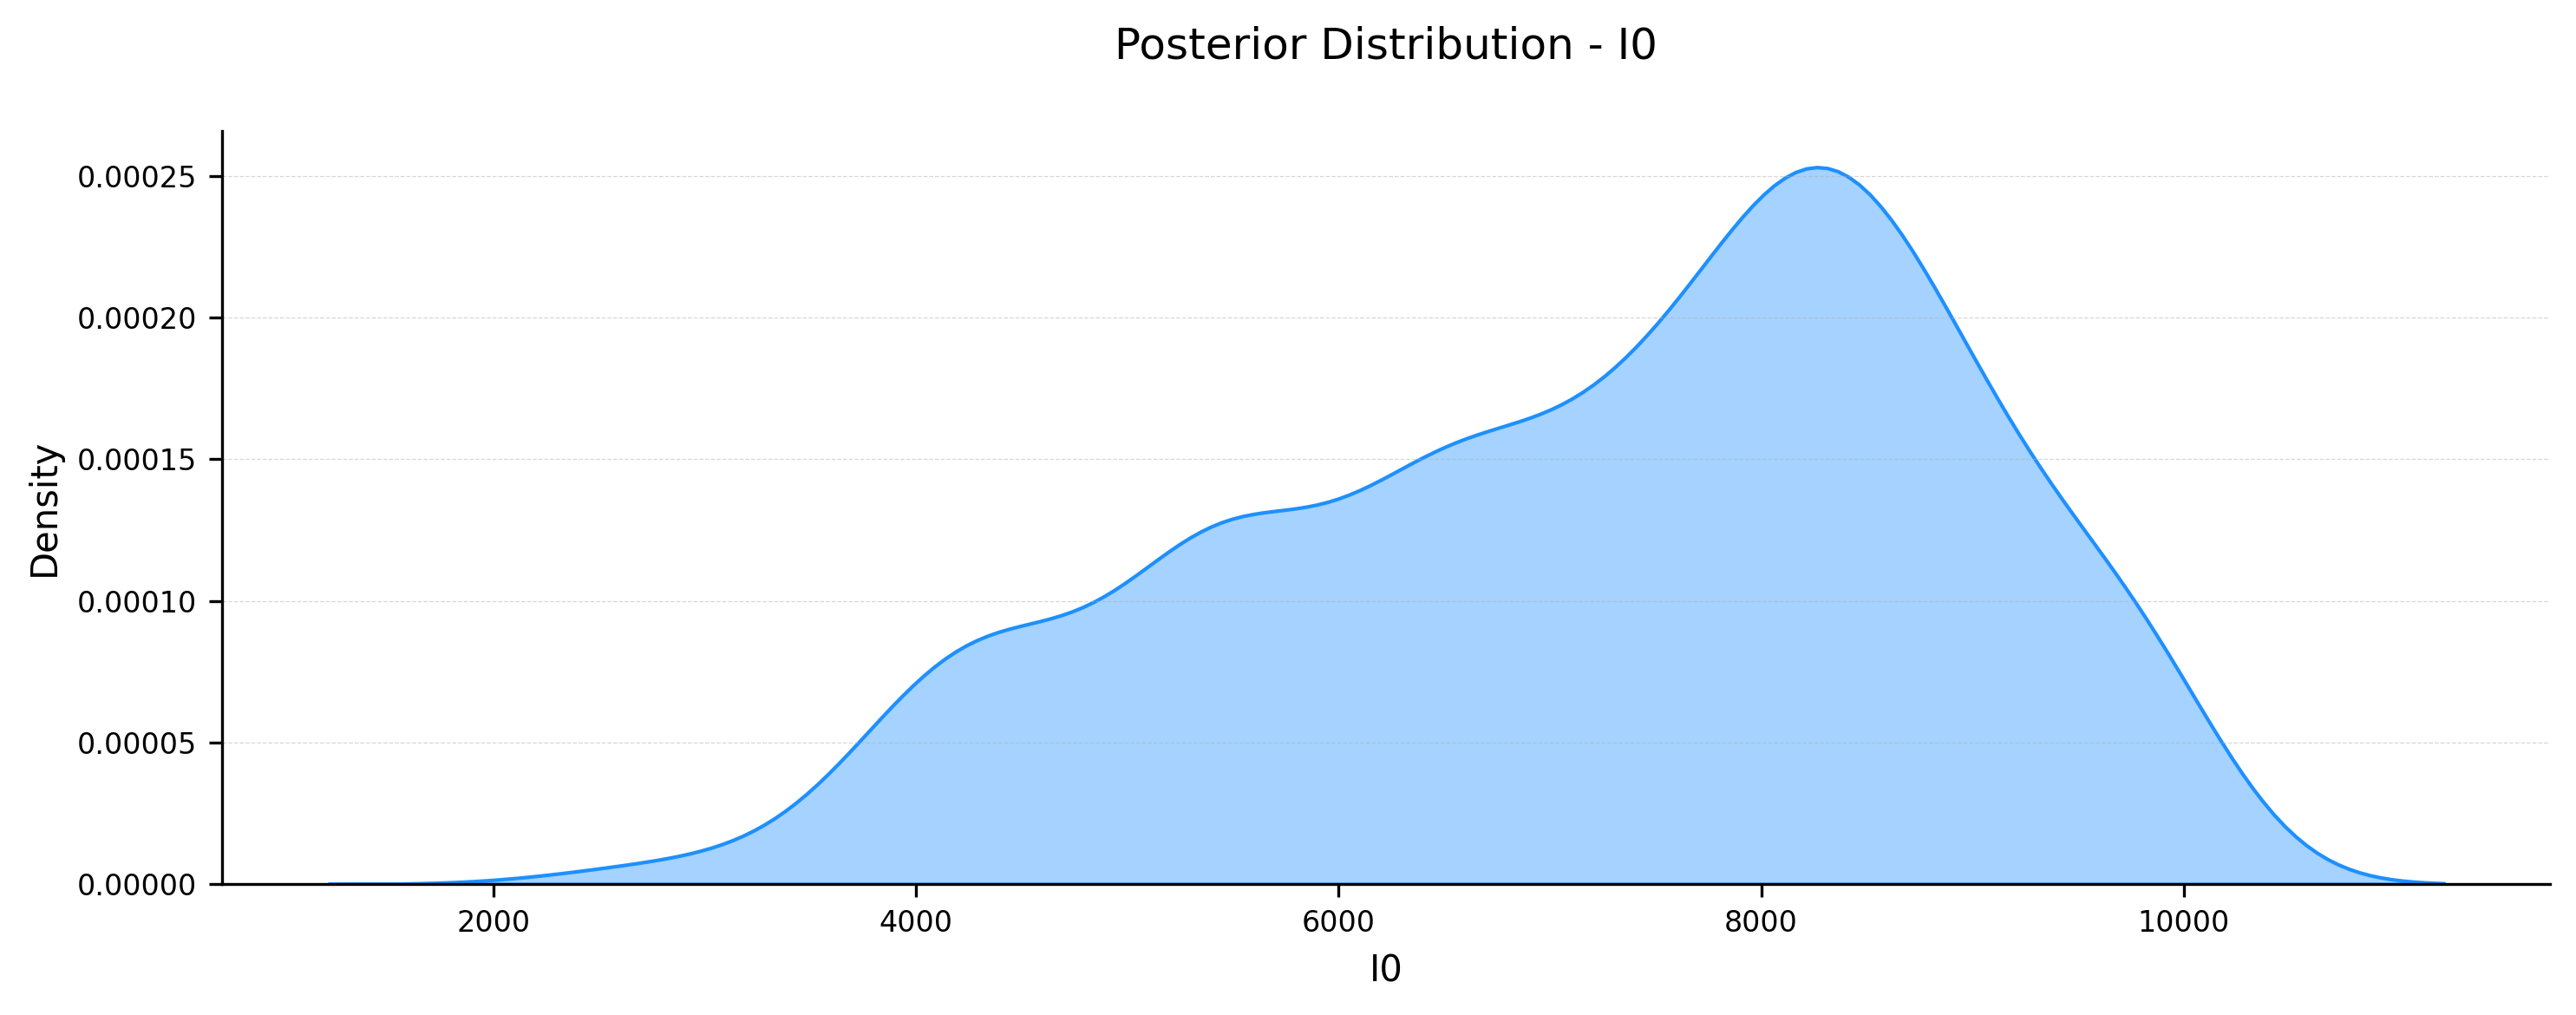

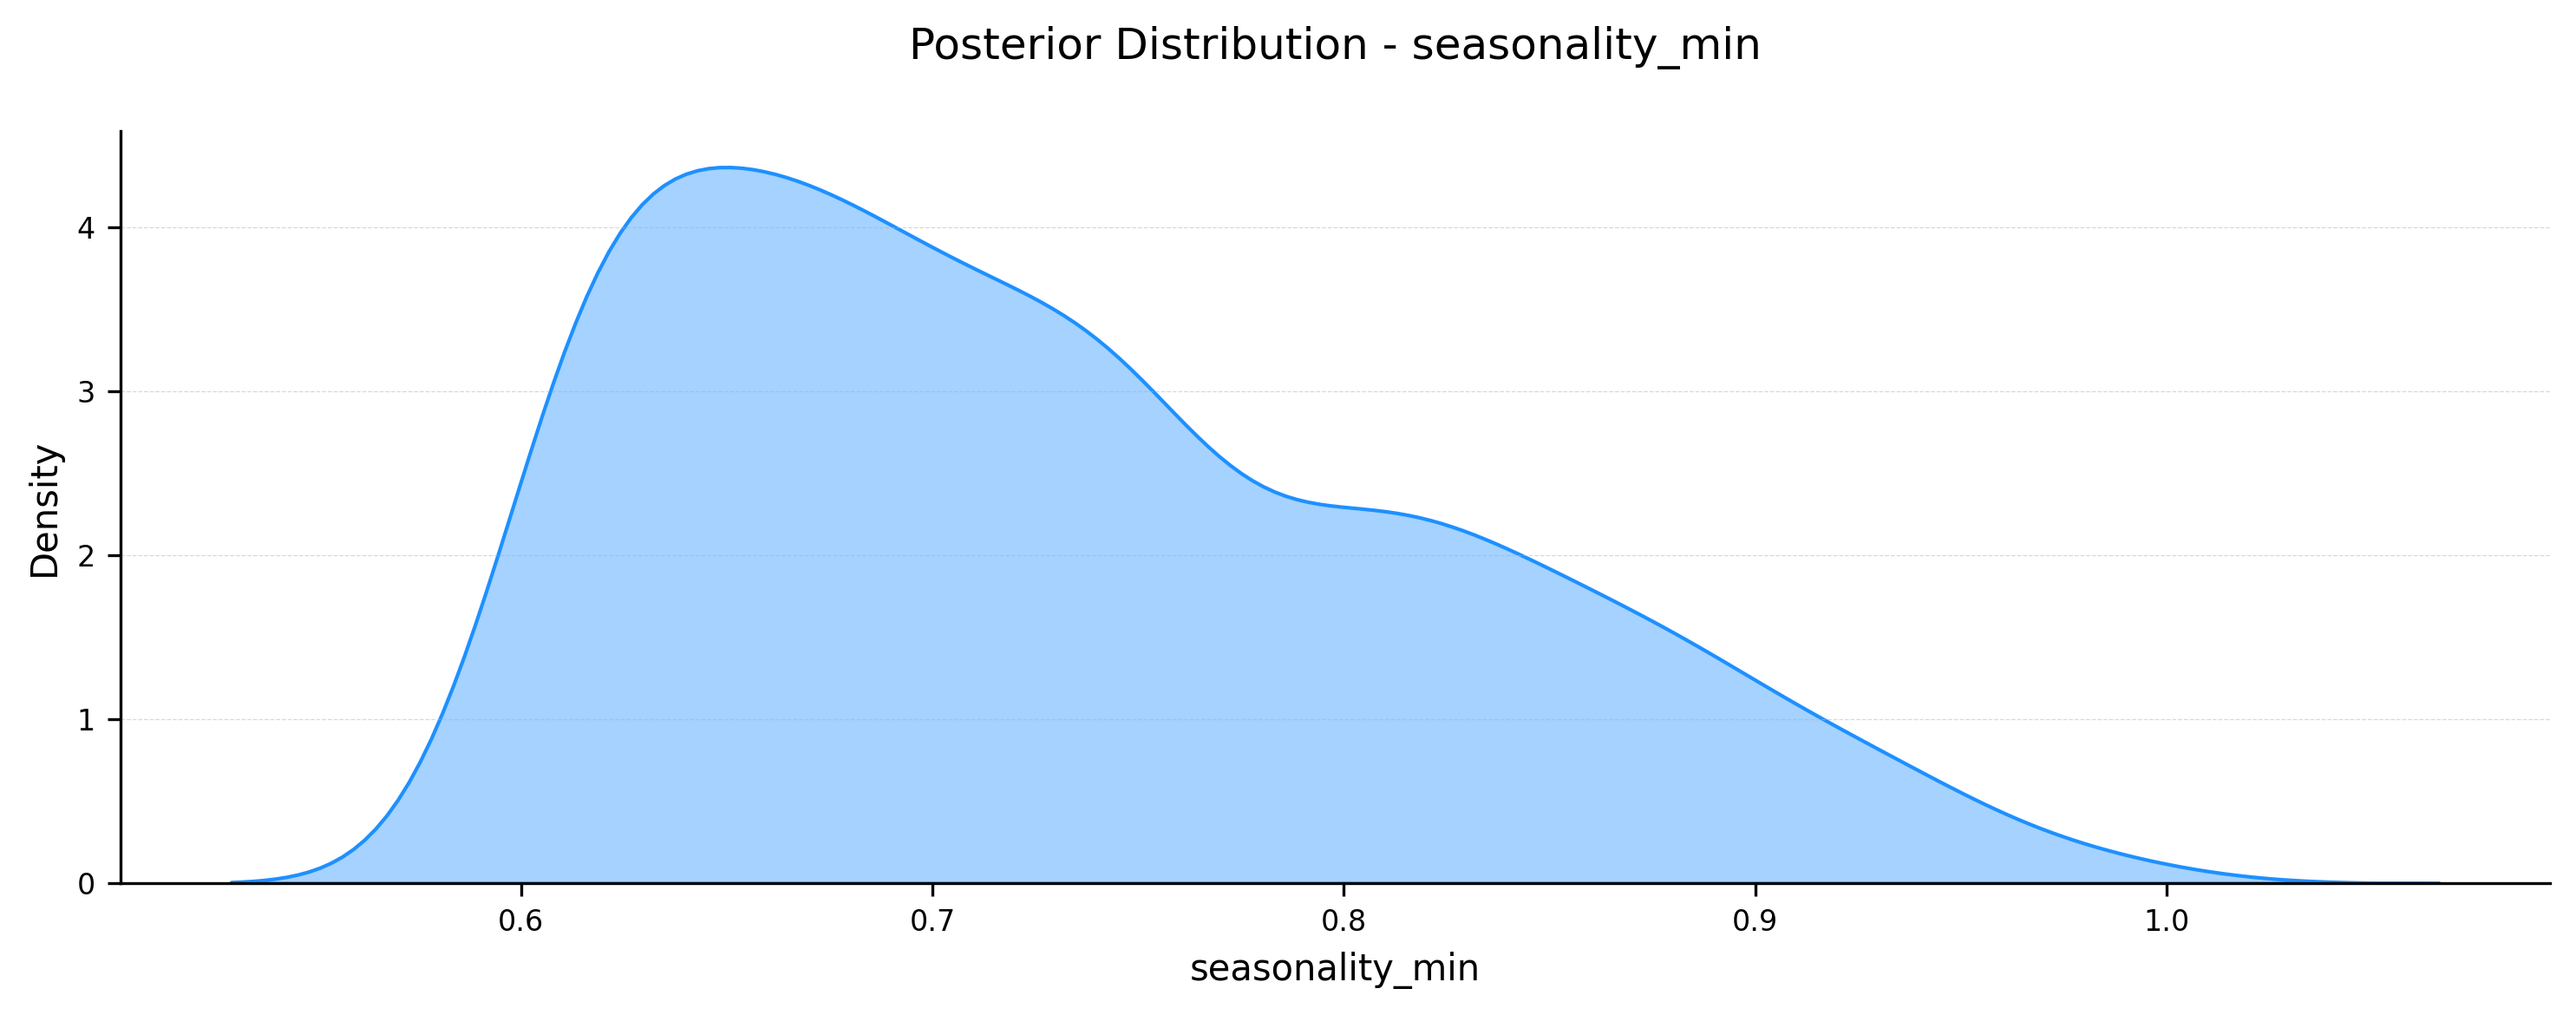

In [19]:
df_posteriors = results.get_posterior_distribution()

for param in ["R0", "Delta", "I0", "seasonality_min"]:
    plot_posterior_distribution(
        df_posteriors,
        parameter=param,
        title=f"Posterior Distribution - {param}",
        xlabel=param,
        ylabel="Density",
        kind="kde",
    )

Finally, we run projections under three different scenarios: 
- A: in the projection phase, contact levels remain equal to the last value observed in the calibration window
- B: in the projection phase, contact levels increase by 30% respect to the last value observed in the calibration window
- C: in the projection phase, contact levels increase by 50% respect to the last value observed in the calibration window

In [12]:
# update simulation dates
simulation_dates = compute_simulation_dates(start_date=epi_data_calibration.date.values[0], end_date=epi_data_projection.date.values[-1])
parameters = {"epimodel": model, 
              "start_date": epi_data_calibration.date.values[0], 
              "end_date": epi_data_projection.date.values[-1], 
              "resample_frequency": "W"}

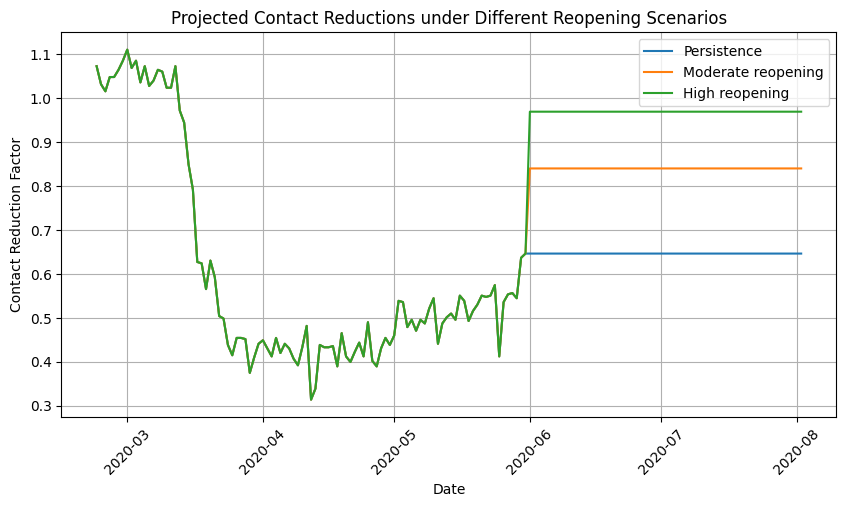

In [13]:
# Generate date ranges for total, calibration, and projection periods
total_dates = pd.date_range(epi_data.date.values[0], epi_data.date.values[-1])
calibration_dates = pd.date_range(epi_data_calibration.date.values[0], epi_data_calibration.date.values[-1])
projection_dates = pd.date_range(epi_data_projection.date.values[0], epi_data_projection.date.values[-1])

# Compute the number of projection time steps
T_proj = len(total_dates) - len(calibration_dates)

# Create a DataFrame for contact reductions over the projection period
contact_reductions_projection = pd.DataFrame({"date": total_dates})

# Define reopening scenarios with different levels of contact increase
r_persistence = contact_reductions["r"].values[-1] * np.ones(T_proj)
r_moderate = 1.3 * contact_reductions["r"].values[-1] * np.ones(T_proj)
r_high = 1.5 * contact_reductions["r"].values[-1] * np.ones(T_proj)

# Extend contact reduction values into the projection period
contact_reductions_projection["r_persistence"] = np.concatenate((contact_reductions["r"].values, r_persistence))
contact_reductions_projection["r_moderate"] = np.concatenate((contact_reductions["r"].values, r_moderate))
contact_reductions_projection["r_high"] = np.concatenate((contact_reductions["r"].values, r_high))

# Plot different reopening scenarios
plt.figure(figsize=(10, 5))
plt.plot(contact_reductions_projection.date, contact_reductions_projection["r_persistence"], label="Persistence")
plt.plot(contact_reductions_projection.date, contact_reductions_projection["r_moderate"], label="Moderate reopening")
plt.plot(contact_reductions_projection.date, contact_reductions_projection["r_high"], label="High reopening")

# Format the plot
plt.legend()
plt.xlabel("Date")
plt.ylabel("Contact Reduction Factor")
plt.title("Projected Contact Reductions under Different Reopening Scenarios")
plt.xticks(rotation=45)
plt.grid(True)

# Show the plot
plt.show()


In [14]:
results_reopening = {}
for reopening in ["persistence", "moderate", "high"]:
    print(f"Running projections for reopening scenario: {reopening}")
    projection_parameters = parameters.copy()
    model.add_parameter("r", contact_reductions_projection[f"r_{reopening}"].values)
    projection_parameters.update({"epimodel": model})
    results_reopening[reopening] = abc_sampler.run_projections(projection_parameters) 


Running projections for reopening scenario: persistence
Running projections for reopening scenario: moderate
Running projections for reopening scenario: high


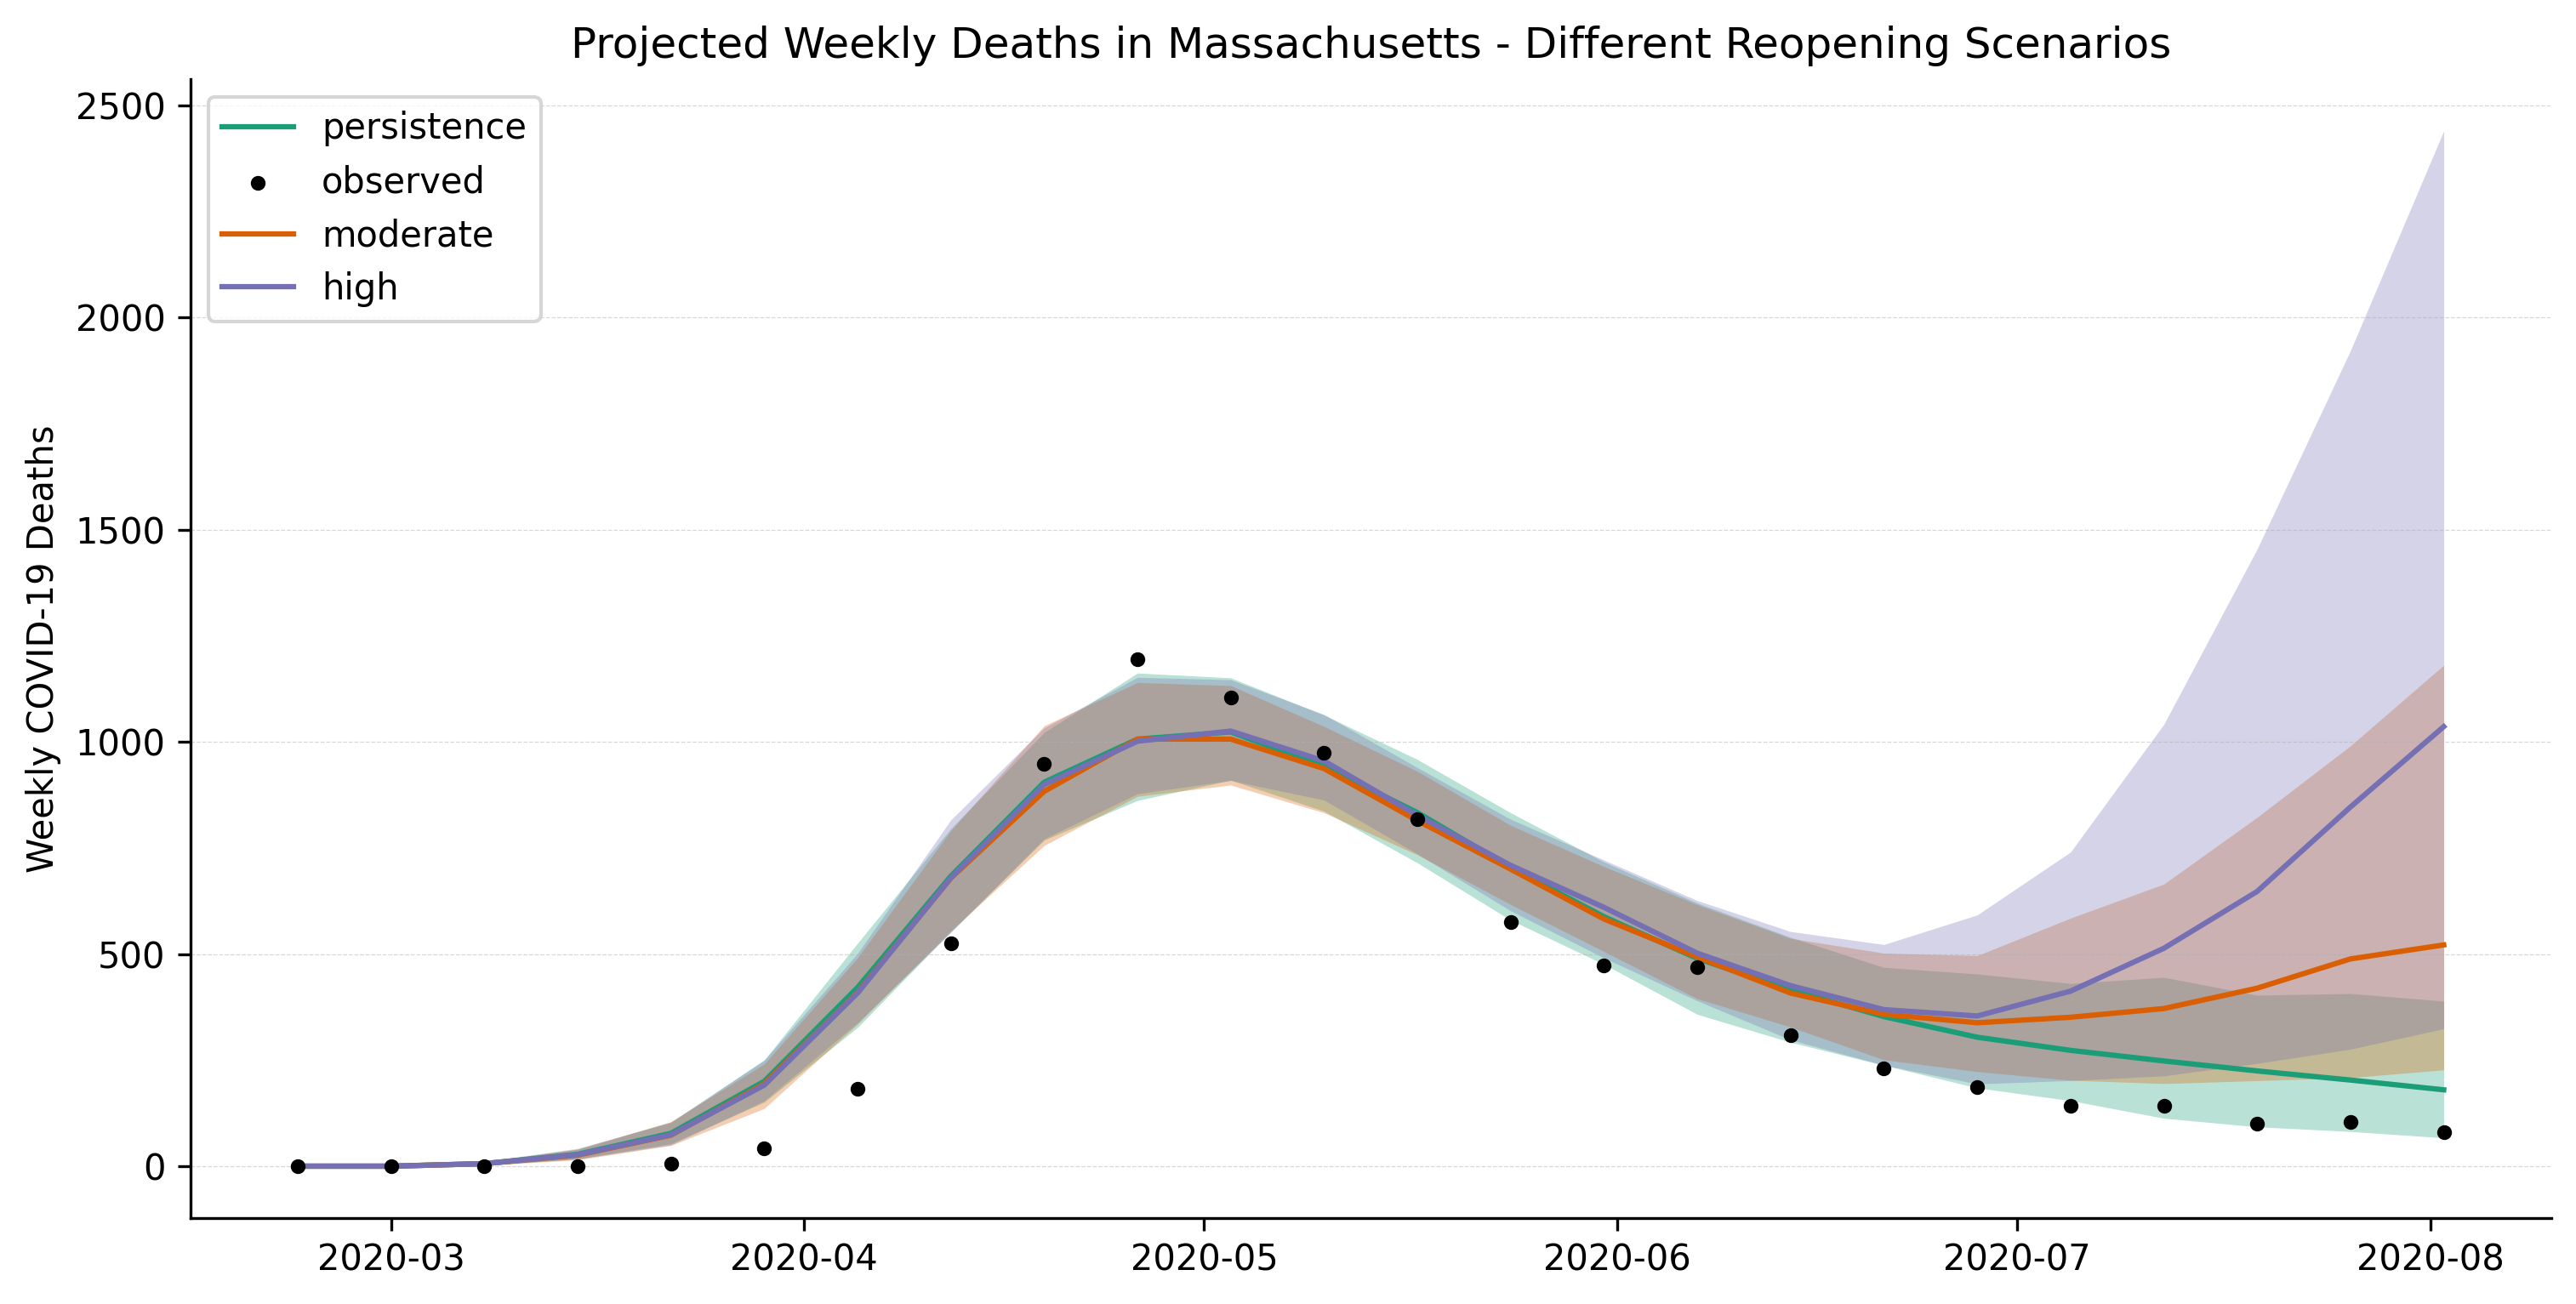

In [15]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

colors = sns.color_palette("Dark2", n_colors=3)
show_data = True
for reopening, color in zip(["persistence", "moderate", "high"], colors): 
    df_quantiles = results_reopening[reopening].get_projection_quantiles(epi_data.date.values)
    plot_quantiles(df_quantiles, columns="data", data=epi_data, ax=ax, colors=color, show_legend=False, show_data=show_data, labels=[reopening])
    show_data = False

ax.set_title("Projected Weekly Deaths in Massachusetts - Different Reopening Scenarios")
ax.legend(loc="upper left")
ax.set_ylabel("Weekly COVID-19 Deaths");